[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Weeds Identification-Object Detection-1

The following notebook is based on the [Ultralytics YOLOv5 tutorial](https://github.com/ultralytics/yolov5).

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.<br>
For this notebook you will need to download the **Broccoli-080919-Healthy-zz-V1-20210225102111** dataset from [Eden Library](https://edenlibrary.ai/datasets), and you may want to use the **eden_pytorch_object_detection.yml** file to recreate a suitable conda environment.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we will cover a technique called **Object Detection**, which generally refers to a process when a machine is trained to detect instances of semantic objects of a certain class (e.g. cats, dogs, flowers) in digital images and videos [1] Specifically, we will using **YOLO object detector** which was first presented in 2016 [2] and was further developed by Ultralytics [3].

In **agriculture** several works have arisen in the last years ranging from detection of crops (e.g. apples) in different growth stages [4], to pest, disease and weed detection in a variety of crops like tomatoes [5] and lettuce [6]. Typing *YOLO, detection, agriculture* in Google Scholar returns more than 7.600 results, with most use cases achieving excellent F1-scores higher than 90%. The main reasons that YOLO has become so popular are:
1. It is really fast.
2. It uses the entire image when training and testing, so it can compute information about each class and its appearance.
3. It can run object detection in real-time.
4. There are available weights that were trained with millions of images and for extensive periods of time which can accelerate the training process.

Regarding the agricultural problem covered in this notebook, **weeds** compete with crops in the domain of space, light and nutrients and, therefore, are an important problem that can lead to a poorer harvest. To avoid this, weeds should be removed at every step of the growth, but especially at the initial stages. For that reason, identifying weeds accurately using deep learning has become an important objective.

## Main Script
### Cloning YOLOv5 repository

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repository
!pip install -qr yolov5/requirements.txt  # install notebook dependencies (ignore errors)

# In case the GPU used is an RTX 30X0, also run:
#!pip install --pre torch torchvision torchaudio -f https://download.pytorch.org/whl/nightly/cu111/torch_nightly.html

Cloning into 'yolov5'...
remote: Enumerating objects: 7003, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 7003 (delta 55), reused 23 (delta 7), pack-reused 6894
Receiving objects: 100% (7003/7003), 9.12 MiB | 5.63 MiB/s, done.
Resolving deltas: 100% (4794/4794), done.


### Library Imports

In [2]:
import torch
from IPython.display import Image
import os
import shutil
from pathlib import Path

### Project Structure

In [3]:
# Check if PyTorch is working properly
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1 _CudaDeviceProperties(name='GeForce RTX 2070', major=7, minor=5, total_memory=7979MB, multi_processor_count=36)


In [4]:
# Name of the dataset downloaded from Eden Library
path = "Broccoli-080919-Healthy-zz-V1-20210225102111"

# Define the source path
SOURCE_IMAGES_PATH = str(
    Path(Path.cwd()).parents[0].joinpath("eden_library_datasets").joinpath(path)
)

# Copying configuration files
shutil.copy("broc.names", "./yolov5")
shutil.copy("broc.yaml", "./yolov5")
shutil.copy("train.txt", "./yolov5")
shutil.copy("val.txt", "./yolov5")

IMAGES_PATH = "yolov5/eden_data/images/"
LABELS_PATH = "yolov5/eden_data/labels/"

os.makedirs(IMAGES_PATH + "train", exist_ok=True)
os.makedirs(IMAGES_PATH + "val", exist_ok=True)
os.makedirs(LABELS_PATH + "train", exist_ok=True)
os.makedirs(LABELS_PATH + "val", exist_ok=True)

conf_files = ["train.txt", "val.txt"]

print("Creating folder structure...")

for conf_file in conf_files:
    with open(conf_file, "r") as reader:
        # Create the yolov5/eden_data/images/train path
        img_dst_dir = IMAGES_PATH + conf_file.split(".")[0]
        # Create the yolov5/eden_data/images/val path
        lab_dst_dir = LABELS_PATH + conf_file.split(".")[0]
        # Read and print the entire file line by line
        line = reader.readline()
        im_files = os.listdir(SOURCE_IMAGES_PATH)
        while line != "":
            aux_im = line.split("/")[-1]
            for im_file in im_files:
                if im_file.strip() == aux_im.strip():
                    img_source = SOURCE_IMAGES_PATH + os.path.sep + im_file.strip()
                    shutil.copy(img_source, img_dst_dir)
                    image_annotation = (
                        SOURCE_IMAGES_PATH
                        + os.path.sep
                        + im_file.strip().split(".")[0]
                        + ".txt"
                    )
                    shutil.copy(image_annotation, lab_dst_dir)
            line = reader.readline()

print("Process finished correctly")

Creating folder structure...
Process finished correctly


In [5]:
# Change directory for easier execution
%cd yolov5

/home/User/Documents/Eden_Library/eden_library_notebooks/object_detection/yolov5


#### Fine-Tuning YOLOv5

In [6]:
# Cleanup previous training data
RUNS_EXP_PATH = "./runs/train/exp"

if os.path.exists(RUNS_EXP_PATH):
    shutil.rmtree(RUNS_EXP_PATH)

In [7]:
# The hyperparameters selected for this dataset:
# IMAGE_SIZE = 320
# BATCH_SIZE = 6
# EPOCHS = 80
# METADATA_FILE = broc.yaml
# WEIGHTS_FILE = yolov5m.pt

# Train model
!python train.py --img 320 --multi-scale --batch 6 --epochs 80 --data broc.yaml --cfg yolov5m.yaml --weights yolov5m.pt --cache

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-164-g0cfc5b2 torch 1.8.1+cu102 CUDA:0 (GeForce RTX 2070, 7979.1875MB)

Namespace(adam=False, artifact_alias='latest', batch_size=6, bbox_interval=-1, bucket='', cache_images=True, cfg='./models/yolov5m.yaml', data='broc.yaml', device='', entity=None, epochs=80, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[320, 320], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=True, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=6, upload_dataset=False, weights='yolov5m.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-06-09 13:23:41.203561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could

### Model Evaluation
**Caution:** The paths below may change if the notebook is not executed sequentially.

#### Training Data sample

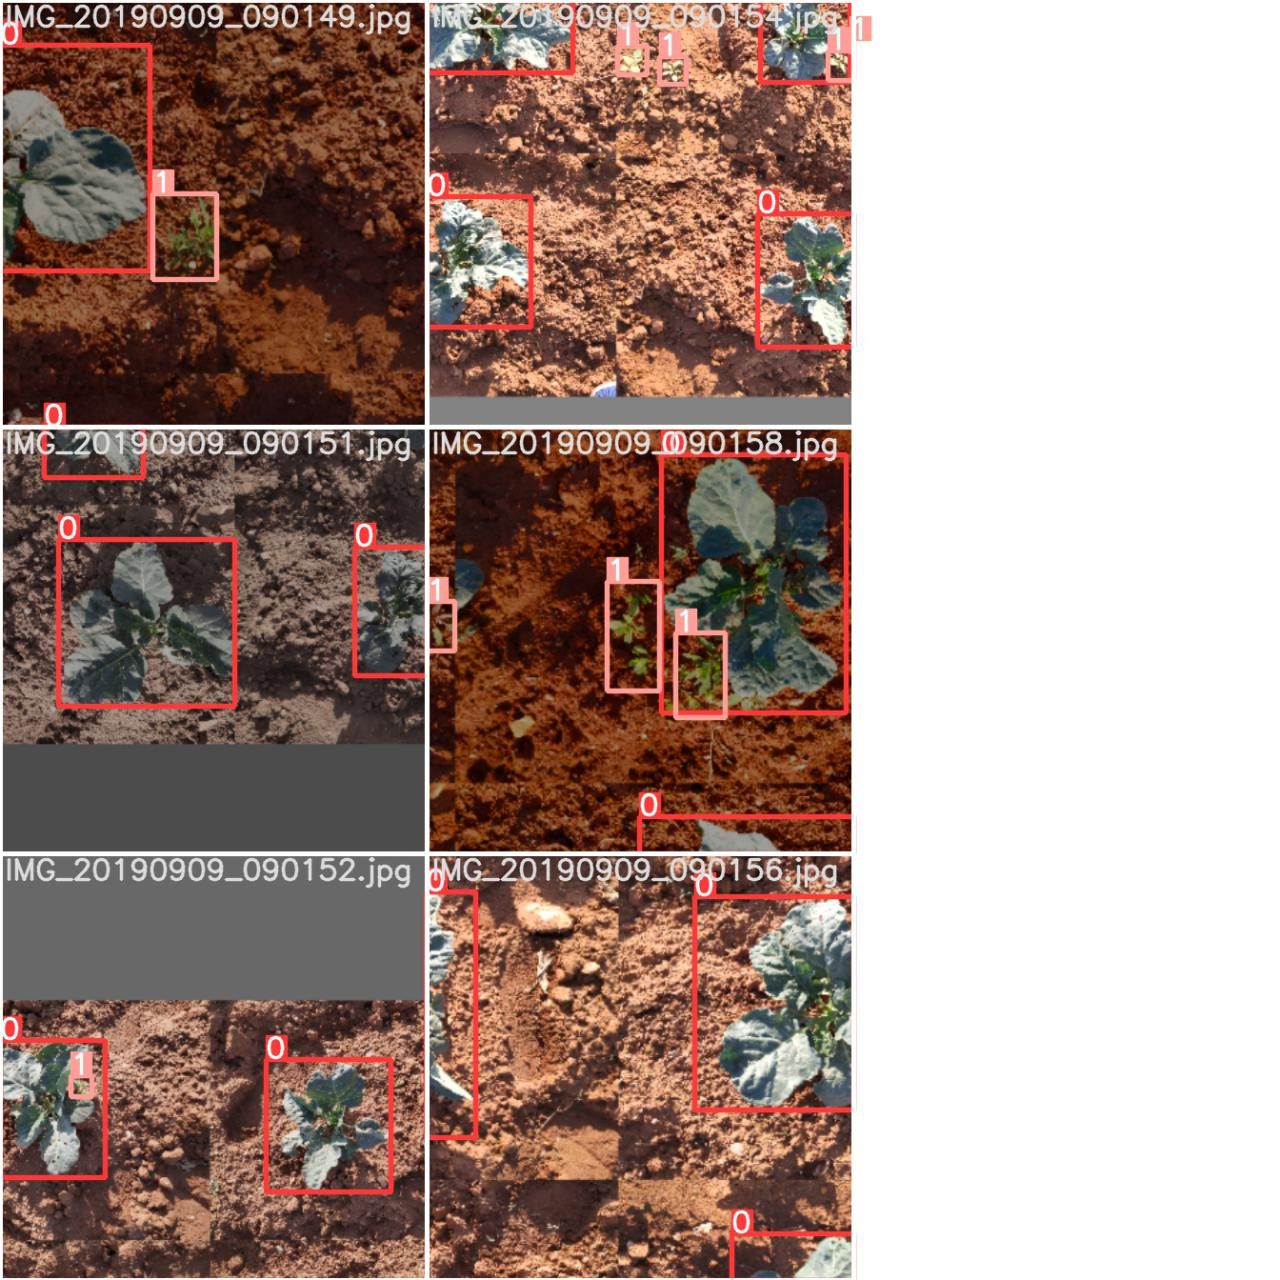

In [8]:
Image(filename="runs/train/exp/train_batch1.jpg", width=900)

#### Testing Data sample

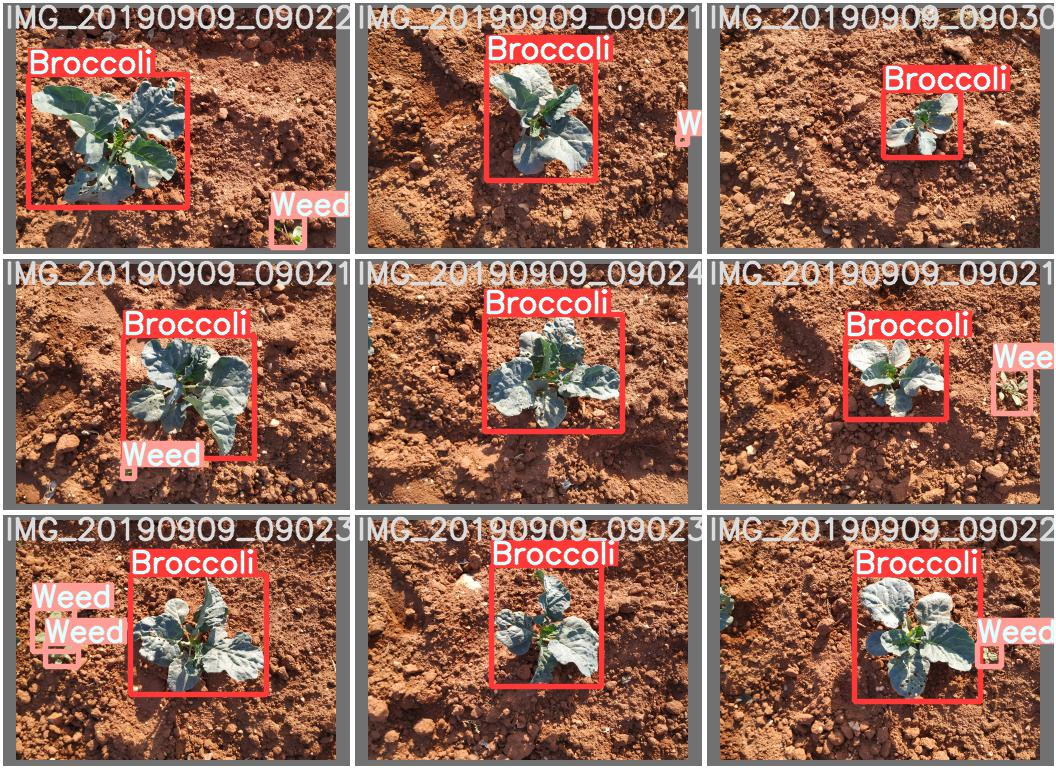

In [9]:
Image(filename="runs/train/exp/test_batch0_labels.jpg", width=900)

### Detecting with YOLOv5
We may now run the object detection model on the validation images using the weights that provided the best results during training.

In [10]:
# Cleanup previous prediction data
RUNS_DET_PATH = "./runs/detect/exp"
if os.path.exists(RUNS_DET_PATH):
    shutil.rmtree(RUNS_DET_PATH)

In [11]:
# Detect objects on validation images
!python detect.py --weights runs/train/exp/weights/best.pt --img 256 --conf 0.49 --source eden_data/images/val/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.49, device='', exist_ok=False, half=False, hide_conf=False, hide_labels=False, img_size=256, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='eden_data/images/val/', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
YOLOv5 🚀 v5.0-164-g0cfc5b2 torch 1.8.1+cu102 CUDA:0 (GeForce RTX 2070, 7979.1875MB)

Fusing layers... 
Model Summary: 308 layers, 21041679 parameters, 0 gradients, 50.3 GFLOPs
image 1/9 /home/User/Documents/Eden_Library/eden_library_notebooks/object_detection/yolov5/eden_data/images/val/IMG_20190909_090212.jpg: 192x256 1 Broccoli, 1 Weed, Done. (0.010s)
image 2/9 /home/User/Documents/Eden_Library/eden_library_notebooks/object_detection/yolov5/eden_data/images/val/IMG_20190909_090214.jpg: 192x256 1 Broccoli, Done. (0.007s)
image 3/9 /home/User/Documents/Eden_Library/eden_libra

### Display YOLOv5's predictions

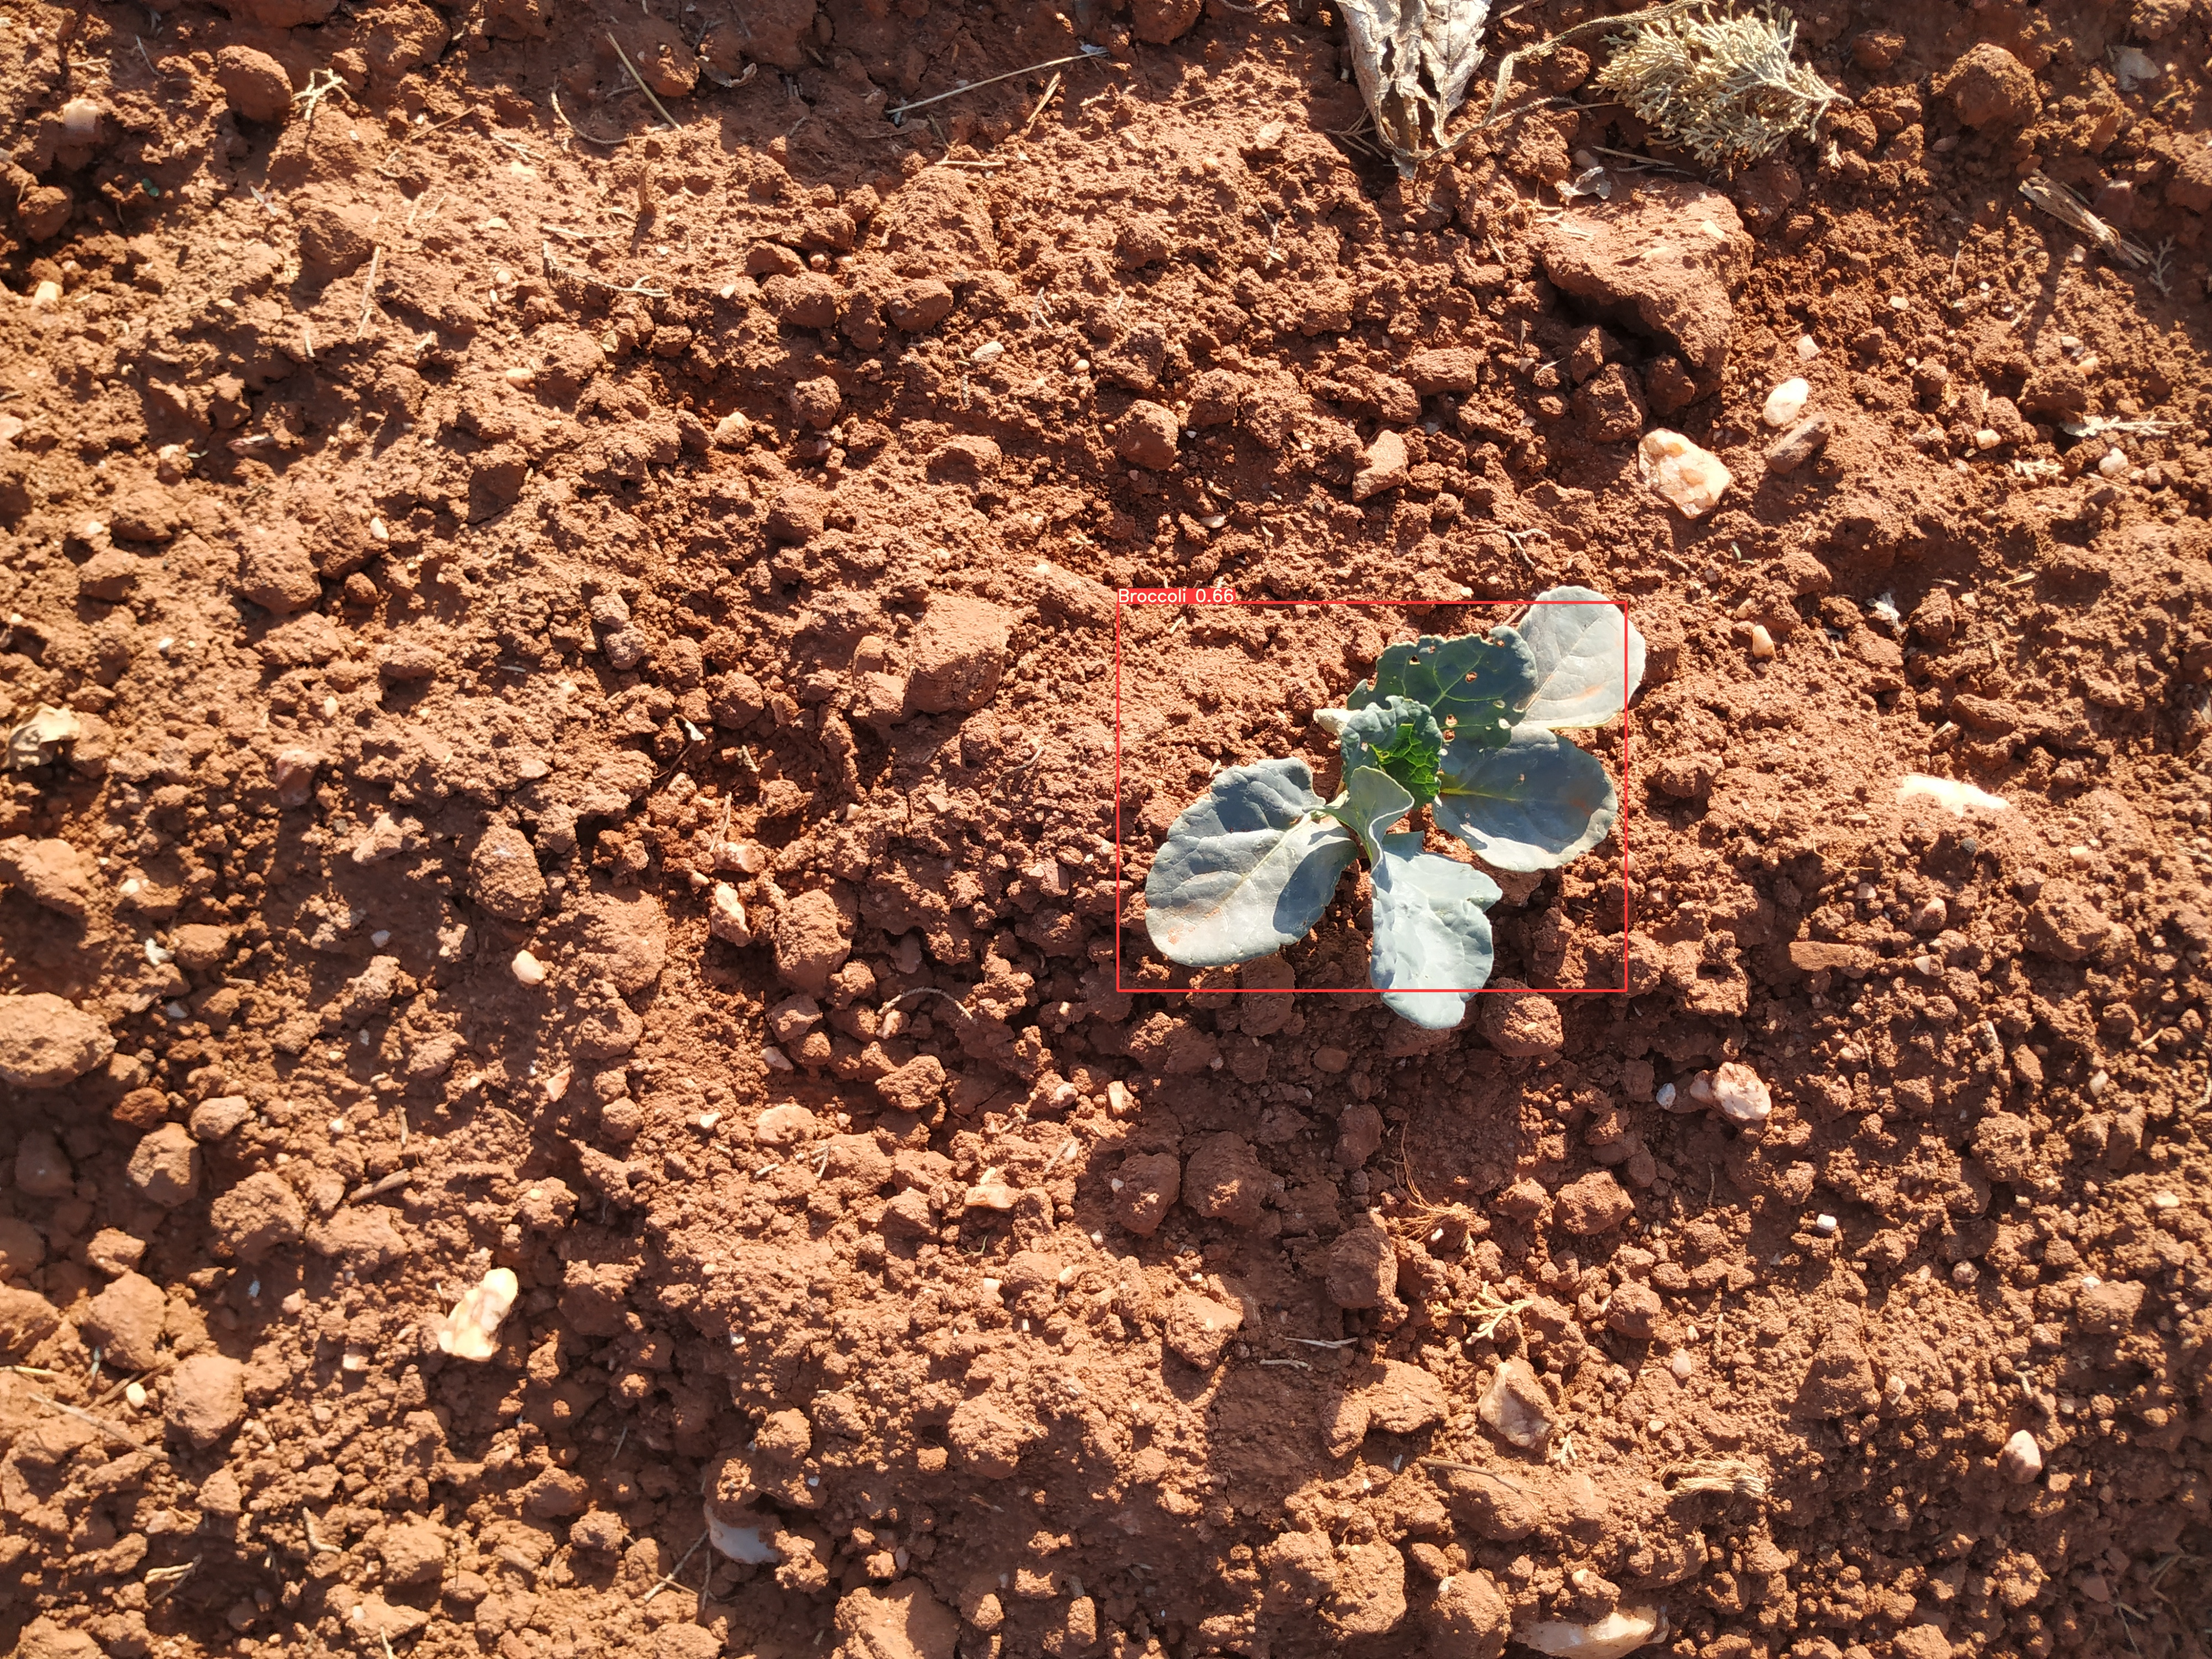

In [12]:
Image(filename="runs/detect/exp/IMG_20190909_090300.jpg", width=600)

## Possible Extensions
1. Change the image size (640x640 is default in Ultralytics' implementation)
2. Try different epochs and batch sizes (we used 80 and 6, respectively)
3. Try the other YOLOv5 models: S/L/X (we used yolov5m.pt)

## Bibliography
<a id='references'></a>

[1] Dasiopoulou, Stamatia, et al. "Knowledge-assisted semantic video object detection." IEEE Transactions on Circuits and Systems for Video Technology 15.10 (2005): 1210-1224.

[2] Redmon, Joseph, et al. "You only look once: Unified, real-time object detection." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

[3] Glenn Jocher, Alex Stoken, Jirka Borovec, NanoCode012, ChristopherSTAN, Liu Changyu, … Lijun Yu 于力军. (2021, January 5). ultralytics/yolov5: v4.0 - nn.SiLU activations, Weights & Biases logging, PyTorch Hub integration (Version v4.0). Zenodo. http://doi.org/10.5281/zenodo.4418161

[4] Tian, Yunong, et al. "Apple detection during different growth stages in orchards using the improved YOLO-V3 model." Computers and electronics in agriculture 157 (2019): 417-426.

[5] Liu, Jun, and Xuewei Wang. "Tomato diseases and pests detection based on improved Yolo V3 convolutional neural network." Frontiers in plant science 11 (2020): 898.

[6] Osorio, Kavir, et al. "A Deep Learning Approach for Weed Detection in Lettuce Crops Using Multispectral Images." AgriEngineering 2.3 (2020): 471-488.